In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

In [2]:
trajs = pd.read_csv('../hrrr17x_0.csv')
# only keep columns callsign, groundspeed, timestamp, latitude, longitude, altitude, track, vertical_rate
trajs = trajs[['callsign', 'groundspeed', 'timestamp', 'latitude', 'longitude', 'altitude', 'track', 'vertical_rate']]
trajs.head()

,callsign,groundspeed,timestamp,latitude,longitude,altitude,track,vertical_rate
0,ABX3122,494.0,2017-01-01 10:00:01+00:00,35.557577,-104.181830,40975.0,98.261289,-64.0
1,GTI3403,511.0,2017-01-01 10:00:01+00:00,32.571996,-99.635682,36900.0,81.552473,0.0
2,AAL8,530.0,2017-01-01 10:00:01+00:00,34.226074,-109.079665,37000.0,85.236358,0.0
3,SKW5364,504.0,2017-01-01 10:00:01+00:00,32.345993,-101.605408,35000.0,80.631176,0.0
4,AAL6,504.0,2017-01-01 10:00:01+00:00,34.304123,-107.654189,36975.0,85.906288,0.0


In [3]:
callsigns = trajs['callsign'].unique()
print('There are {} unique callsigns'.format(len(callsigns)))

There are 31 unique callsigns


# Step 1: Drop callsigns that are in the TMA at the beginning

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# Add search path 
import sys
sys.path.append('../wx')

In [6]:
from roi import KDFW, ROI_RADIUS, WX_ROI # KDFW coordinates

Haversine formula to calculate distance between two points on a sphere

In [7]:
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert coordinates from degrees to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance # in kilometers


In [8]:
# Calculate distance for each row
trajs['distance'] = haversine(trajs['latitude'], trajs['longitude'], KDFW[1], KDFW[0]) # KDFW[1] is latitude, KDFW[0] is longitude

In [9]:
# Compute the max distance for each callsign
max_distance_per_callsign = trajs.groupby('callsign')['distance'].max()

# Callsigns that are within the radius
callsigns_to_drop = max_distance_per_callsign[max_distance_per_callsign < ROI_RADIUS].index
print('There are {} callsigns within the radius to be dropped'.format(len(callsigns_to_drop)))

# Drop callsigns that are within the radius
trajs = trajs[~trajs['callsign'].isin(callsigns_to_drop)]

There are 0 callsigns within the radius to be dropped


# Drop callsigns that haven't landed

In [10]:
# Compute the max distance for each callsign
min_distance_per_callsign = trajs.groupby('callsign')['distance'].min()

# Callsigns that are within the radius
callsigns_to_drop_2 = min_distance_per_callsign[min_distance_per_callsign > 30].index # 4km within the airport is considered as at the airport
print('There are {} callsigns that haven\'t landed and was dropped'.format(len(callsigns_to_drop_2)))

# Drop callsigns that are within the radius
trajs = trajs[~trajs['callsign'].isin(callsigns_to_drop_2)]

There are 18 callsigns that haven't landed and was dropped


In [11]:
print('In the end there are {} callsigns left'.format(len(trajs['callsign'].unique())))

In the end there are 13 callsigns left


# Plotting of a sample trajectory

In [12]:
from viz import plot_traj_from_df, plot_setup
from cartopy import crs as ccrs

## Weather download and preparation

In [13]:
from herbie import Herbie 

In [14]:
H = Herbie(
    "2017-01-01 10:00:01",  # model run date
    model="hrrr",  # model name
    product="sfc",  # model produce name (model dependent)
    fxx=0,  # forecast lead time
)

H.download(":VIL:")

ds = H.xarray(":VIL:")
vil = ds.veril

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2017-Jan-01 10:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/opt/anaconda3/envs/traffic/lib/python3.10/site-packages/herbie/core.py:1052: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


In [15]:
# Forming a mask of the ROI
roi_lon = WX_ROI[0]
roi_lat = WX_ROI[1]

mask_lon = np.logical_and(vil['longitude'].values - 360 > roi_lon[0], vil['longitude'].values - 360 < roi_lon[1])
mask_lat = np.logical_and(vil['latitude'].values > roi_lat[0], vil['latitude'].values < roi_lat[1])
mask = np.logical_and(mask_lon, mask_lat)

In [16]:
# Change values of vil out of the mask to -10
# vil.values[~mask] = -100

A little visualization

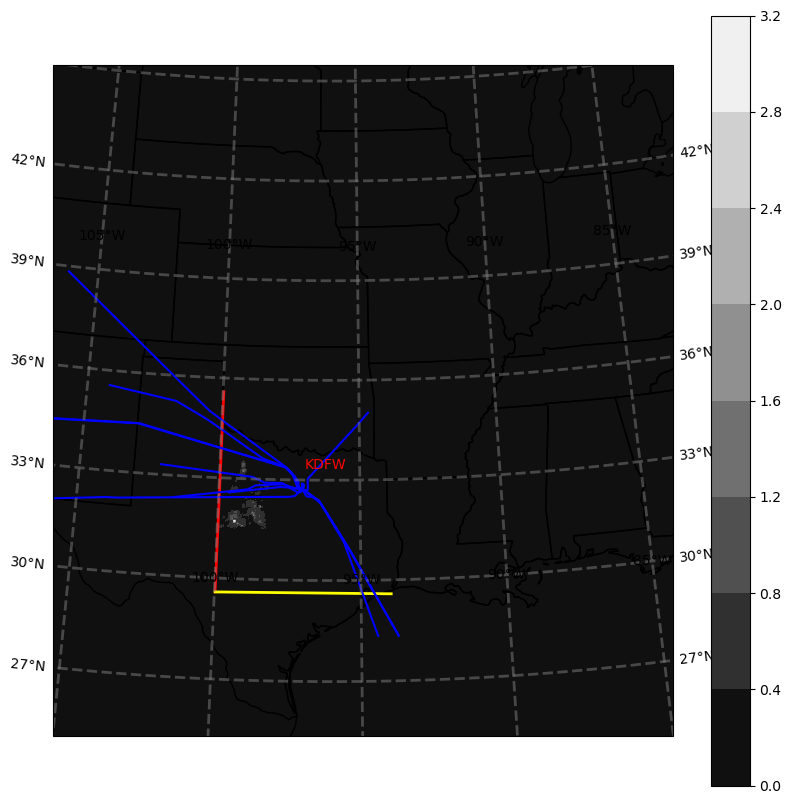

In [17]:
fig, ax = plot_setup()

# Draw two lines, one for each meridian and parallel that we want to highlight.
ax.plot([WX_ROI[0][0], WX_ROI[0][0]], [WX_ROI[1][0], WX_ROI[1][1]], color='red', transform=ccrs.PlateCarree(), linewidth=2)
ax.plot([WX_ROI[0][0], WX_ROI[0][1]], [WX_ROI[1][0], WX_ROI[1][0]], color='yellow', transform=ccrs.PlateCarree(), linewidth=2)

# Overlaying the VIL data on the map
plt.contourf(vil['longitude'].values, vil['latitude'].values, np.where(mask, vil.values, 0), transform=ccrs.PlateCarree(), cmap='gray')
plt.colorbar() 

for csg in trajs['callsign'].unique():
    plot_traj_from_df(trajs, csg, ax)

# Trim the Trajectory

In [18]:
callsigns = trajs['callsign'].unique()
print('There are {} unique callsigns'.format(len(callsigns)))

There are 13 unique callsigns


We trim the trajectories to ROI_RADIUS

In [19]:
trajs_roi = trajs[trajs['distance'] <= ROI_RADIUS]
print('{} rows -> {} rows'.format(len(trajs), len(trajs_roi)))

41484 rows -> 17853 rows


We compute the time of first appearance of each callsign inside the ROI:

In [20]:
callsign_roi_entrance_time = trajs_roi.groupby('callsign')['timestamp'].min().reset_index()

In [21]:
callsign_roi_entrance_time

,callsign,timestamp
0,AAL1122,2017-01-01 10:45:28+00:00
1,AAL1177,2017-01-01 10:13:21+00:00
2,AAL230,2017-01-01 10:50:04+00:00
3,AAL6,2017-01-01 10:53:40+00:00
4,AAL8,2017-01-01 10:59:14+00:00
5,AAL962,2017-01-01 10:22:45+00:00
6,AAL996,2017-01-01 10:30:50+00:00
7,AAR242,2017-01-01 10:25:58+00:00
8,ABX3122,2017-01-01 10:36:54+00:00
9,ASA660,2017-01-01 11:07:45+00:00


In [22]:
import datetime

# Rounding function
def round_to_nearest_half_hour(ts):
    # Extract minutes
    minutes = ts.minute
    # Determine if we should round up or down
    if minutes < 30:
        return ts.replace(minute=0, second=0, microsecond=0)
    else:
        return ts.replace(minute=30, second=0, microsecond=0)

In [23]:
# Convert timestamp strings to datetime
callsign_roi_entrance_time['timestamp'] = pd.to_datetime(callsign_roi_entrance_time['timestamp'])
callsign_roi_entrance_time['rounded_timestamp'] = callsign_roi_entrance_time['timestamp'].apply(round_to_nearest_half_hour)

# Convert rounded_timestamp back to string
callsign_roi_entrance_time['rounded_timestamp'] = callsign_roi_entrance_time['rounded_timestamp'].dt.strftime('%Y-%m-%d %H_%M_%S')

In [24]:
callsign_roi_entrance_time

,callsign,timestamp,rounded_timestamp
0,AAL1122,2017-01-01 10:45:28+00:00,2017-01-01 10_30_00
1,AAL1177,2017-01-01 10:13:21+00:00,2017-01-01 10_00_00
2,AAL230,2017-01-01 10:50:04+00:00,2017-01-01 10_30_00
3,AAL6,2017-01-01 10:53:40+00:00,2017-01-01 10_30_00
4,AAL8,2017-01-01 10:59:14+00:00,2017-01-01 10_30_00
5,AAL962,2017-01-01 10:22:45+00:00,2017-01-01 10_00_00
6,AAL996,2017-01-01 10:30:50+00:00,2017-01-01 10_30_00
7,AAR242,2017-01-01 10:25:58+00:00,2017-01-01 10_00_00
8,ABX3122,2017-01-01 10:36:54+00:00,2017-01-01 10_30_00
9,ASA660,2017-01-01 11:07:45+00:00,2017-01-01 11_00_00


We then compute the number of rows for each callsign

In [25]:
callsign_counts = trajs_roi.groupby('callsign').size().reset_index(name='row_count')

In [26]:
callsign_counts

,callsign,row_count
0,AAL1122,1411
1,AAL1177,1505
2,AAL230,1300
3,AAL6,1365
4,AAL8,1305
5,AAL962,1616
6,AAL996,1472
7,AAR242,1558
8,ABX3122,1261
9,ASA660,1268


# Writing STX Dataset

For preprocessing of trajectory data, we will define following parameters:

- $t_{max} = 2000s$, or around 33 minutes of flight maximum for each trajectory.
- $n_{f,max} = 12$ flights/30 minutes

In [37]:
def trim_and_resample(df, callsign, desired_length = 2000):
    df = df[df['callsign'] == callsign]
    # convert df['timestamp'] to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')
    # fill NaN values 
    df.fillna(method='ffill', inplace=True)
    df = df.resample('1s').agg({
        'callsign': 'ffill',
        'groundspeed': 'mean',
        'latitude': 'mean',
        'longitude': 'mean',
        'altitude': 'mean',
        'track': 'mean',
        'vertical_rate': 'mean'
    })
    df = df.reset_index()
    df = df.interpolate()
    if len(df) > desired_length:
        # trim the trajectory to desired length
        df = df.iloc[0:desired_length]
    elif len(df) < desired_length:
        # repeat the last row until desired length is reached
        last_row = df.iloc[-1]
        while len(df) < desired_length:
            df = pd.concat([df, last_row.to_frame().T])
    return df

In [38]:
aal1122 = trim_and_resample(trajs_roi, 'AAL1122')

/var/folders/lm/mmss816142xg1l8dk_cq_j_h0000gn/T/ipykernel_1780/4062992935.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])
/var/folders/lm/mmss816142xg1l8dk_cq_j_h0000gn/T/ipykernel_1780/4062992935.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/var/folders/lm/mmss816142xg1l8dk_cq_j_h0000gn/T/ipykernel_1780/4062992935.py:18: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate()


In [41]:
aal1122[['latitude', 'longitude']].to_numpy().T.reshape(1, 2, -1)

array([[[31.21646118164062, 31.21802378509004, 31.22137554621292, ...,
         32.87860107421875, 32.87860107421875, 32.87860107421875],
        [-95.59941908892466, -95.60050048828124, -95.60269775390624,
         ..., -97.05097045898437, -97.05097045898437,
         -97.05097045898437]]], dtype=object)

In [43]:
storm_idents = callsign_roi_entrance_time['rounded_timestamp'].unique().tolist()

In [44]:
import os
desired_length = 2000

for storm_ident in storm_idents:
    print('Processing storm {}'.format(storm_ident))
    callsign_of_storm = callsign_roi_entrance_time[callsign_roi_entrance_time['rounded_timestamp'] == storm_ident]['callsign'].tolist()

    big_trajectory = np.empty((0, 2, desired_length))
    for callsign in callsign_of_storm:
        processed_trajectory_df = trim_and_resample(trajs_roi, callsign, desired_length)
        # create a new np array
        processed_trajectory = processed_trajectory_df[['latitude', 'longitude']].to_numpy().T.reshape(1, 2, -1)
        # concatenate to big_trajectory
        big_trajectory = np.concatenate((big_trajectory, processed_trajectory), axis=0)
    
    # save the big_trajectory
    np.savez_compressed(os.path.join('stx', storm_ident), big_trajectory)

Processing storm 2017-01-01 10_30_00


/var/folders/lm/mmss816142xg1l8dk_cq_j_h0000gn/T/ipykernel_1780/4062992935.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])
/var/folders/lm/mmss816142xg1l8dk_cq_j_h0000gn/T/ipykernel_1780/4062992935.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/var/folders/lm/mmss816142xg1l8dk_cq_j_h0000gn/T/ipykernel_1780/4062992935.py:18: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate()
/var/folders/lm/mmss816142xg1l8dk_cq_j_h0000

Processing storm 2017-01-01 10_00_00


/var/folders/lm/mmss816142xg1l8dk_cq_j_h0000gn/T/ipykernel_1780/4062992935.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])
/var/folders/lm/mmss816142xg1l8dk_cq_j_h0000gn/T/ipykernel_1780/4062992935.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/var/folders/lm/mmss816142xg1l8dk_cq_j_h0000gn/T/ipykernel_1780/4062992935.py:18: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate()
/var/folders/lm/mmss816142xg1l8dk_cq_j_h0000

Processing storm 2017-01-01 11_00_00


/var/folders/lm/mmss816142xg1l8dk_cq_j_h0000gn/T/ipykernel_1780/4062992935.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])
/var/folders/lm/mmss816142xg1l8dk_cq_j_h0000gn/T/ipykernel_1780/4062992935.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/var/folders/lm/mmss816142xg1l8dk_cq_j_h0000gn/T/ipykernel_1780/4062992935.py:18: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate()


# Testing the written trajectory

In [45]:
storm1_trajs = np.load('stx/2017-01-01 10_00_00.npz', allow_pickle=True)['arr_0']

In [49]:
from viz import plot_traj_from_np_array

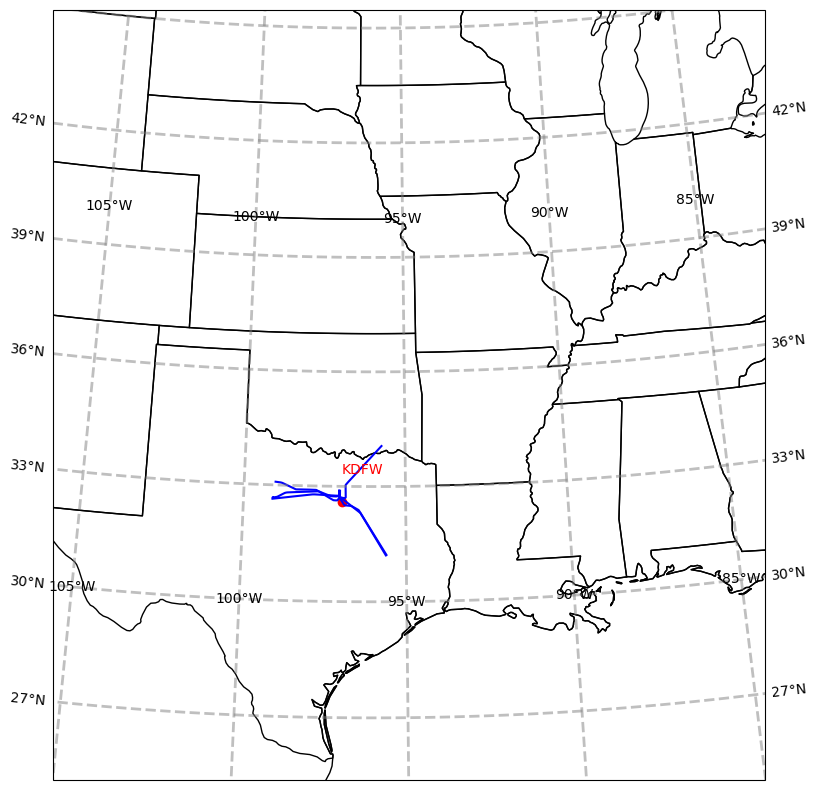

In [52]:
fig, ax = plot_setup()

for i in range(len(storm1_trajs)):
    plot_traj_from_np_array(storm1_trajs[i,:,:], ax)